# 3. Building and evaluating different models

#### Procedure
- Training data set (which has been embedded) will be run on different models and evaluated using the validation set. 

I expect that the data should be heavily regularized. I'll take care of that when I've found the most promising model. 

When the 'winning' model has been regularized and fine-tuned using cross-validation, the model will be tested on the test set, and the results will be reported.


In [1]:
# important packages 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error 
from sklearn.metrics import r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge

## random forrest og feature importance 
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
import pickle as pkl
import shap


/work/datascience_exam/env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Loading data

In [2]:
# load data which has been embedded, clustered and dimensionality reduced using PCA
train = pd.read_csv('/work/datascience_exam/data/train_features.csv', index_col = 0)

X_train = train.iloc[:,:237] # all columns but the last one which is 'Age of Death'
y_train = train.loc[:,'Age of death']

In [3]:
# loading validation dataset
val = pd.read_csv('/work/datascience_exam/data/val_features.csv', index_col = 0)

X_val = val.iloc[:,:237] # all columns but the last one which is 'Age of Death'
y_val = val.loc[:,'Age of death']

In [4]:
# loading test data
test = pd.read_csv('/work/datascience_exam/data/test_features.csv', index_col = 0)

X_test = test.iloc[:,:237] # all columns but the last one which is 'Age of Death'
y_test = test.loc[:,'Age of death']

In [117]:
X_train.head()

,Gender_encode,Birth year,Occupation_cluster,country1,country2,country3,country4,country5,country6,country7,...,description143,description144,description145,description146,description147,description148,description149,description150,description151,description152
0,2,1915,1,-0.203594,-0.144200,0.094234,-0.186961,0.011282,-0.267115,0.042559,...,-0.002223,0.031173,-0.015610,0.021765,-0.043946,-0.055602,0.099160,0.005596,0.025316,0.010624
1,1,1915,0,-0.201265,-0.031549,0.048032,-0.224219,-0.395700,0.084482,-0.024386,...,0.010041,-0.029504,-0.007824,0.001081,0.023954,-0.006589,-0.006589,0.017155,-0.019700,-0.009435
2,1,1923,0,-0.273769,-0.121739,-0.152663,0.409265,-0.110530,0.146183,0.105975,...,-0.003499,0.002186,0.005657,0.013795,0.006256,-0.000399,0.004402,-0.004409,0.008620,0.000956
3,1,1918,2,-0.349983,-0.160185,-0.229322,-0.122732,0.266424,0.049163,-0.095842,...,0.011873,0.013108,-0.010277,-0.005705,0.001044,-0.009338,0.039861,0.008489,-0.014900,-0.028253
4,1,1856,3,-0.029722,0.303856,0.063169,-0.040947,0.083048,-0.158634,0.014466,...,0.027537,-0.052587,-0.002195,0.020234,0.008825,-0.071778,0.031260,0.011545,0.020523,0.016538


## Building models

I want to build the following models:

- Model 1: A 'dummy' model with only the mean of y as feature
- Model 2: A 'baseline' model 
    - one which only includes 'gender' as a feature
    - one which only includes 'birth year' as a feature
- Model 3: The full model which includes all predictors. 

Model 1 and 2 will be modelled as a linear regression. 

Model 3 will be modelled as a linear regression, KNN-regression and a random forrest.


In [5]:
performances = []

In [44]:
### Dummy model

mean_value = y_train.mean()

performance = np.sqrt(mean_squared_error(y_val, [mean_value]*len(y_val)))
r2 = r2_score(y_val, [mean_value]*len(y_val))
performances.append({'model': 'dummy',
                     'split': 'validation',
                     'rmse': performance.round(4),
                     'r2': r2.round(4)})

In [45]:
### Baseline model - only predictor is gender - linear regression

gender_train = X_train.loc[:, ['Gender_encode']]
gender_val = X_val.loc[:, ['Gender_encode']]

reg = LinearRegression().fit(gender_train, y_train)

preds =  reg.predict(gender_val)
r2 = r2_score(y_val, preds)
performance = np.sqrt(mean_squared_error(y_val, preds))
performances.append({'model': 'linear-gender',
                     'split': 'validation',
                     'rmse': performance.round(4),
                     'r2': r2.round(4)})

In [49]:
### Baseline model - only predictor is birth year - linear regression

birth_year_train = X_train.loc[:, ['Birth year']]
birth_year_val = X_val.loc[:, ['Birth year']]

reg = LinearRegression().fit(birth_year_train, y_train)

preds =  reg.predict(birth_year_val)
r2 = r2_score(y_val, preds)
performance = np.sqrt(mean_squared_error(y_val, preds))
performances.append({'model': 'linear-birth_year',
                        'split': 'validation',
                        'rmse': performance.round(4),
                        'r2': r2.round(4)})

In [51]:
### full linear model (includes all features)

reg = LinearRegression().fit(X_train, y_train)

preds =  reg.predict(X_val)
r2 = r2_score(y_val, preds)
performance = np.sqrt(mean_squared_error(y_val, preds))
performances.append({'model': 'linear-full',
                         'split': 'validation',
                         'rmse': performance.round(4),
                         'r2': r2.round(4)})

In [57]:
# full linear model (includes all features) - with lasso regularization
reg = Lasso().fit(X_train, y_train)

preds = reg.predict(X_val)
r2 = r2_score(y_val, preds)
performance = np.sqrt(mean_squared_error(y_val, preds))
performances.append({'model': 'linear_lasso_alpha_1.0',
                         'split': 'validation',
                         'rmse': performance.round(4),
                         'r2': r2.round(4)})

In [58]:
# full linear model (includes all features) - with ridge regularization
reg = Ridge().fit(X_train, y_train)

preds = reg.predict(X_val)
r2 = r2_score(y_val, preds)
performance = np.sqrt(mean_squared_error(y_val, preds))
performances.append({'model': 'linear_ridge_alpha_1.0',
                         'split': 'validation',
                         'rmse': performance.round(4),
                         'r2': r2.round(4)})

In [61]:
# KNN (non-parametric) linear regression

k = 10
neigh = KNeighborsRegressor(n_neighbors=k)
neigh.fit(X_train, y_train)

preds = neigh.predict(X_val)
r2 = r2_score(y_val, preds)
performance = np.sqrt(mean_squared_error(y_val, preds))
performances.append({'model': f'knn-allpreds-{k}',
                        'split': 'validation',
                        'rmse': performance.round(4),
                        'r2': r2.round(4)})

In [62]:
# save model
pkl.dump(neigh, file=open(f'/work/datascience_exam/output/models/knn-allpreds-{k}.pkl', 'wb')) # save the model

In [21]:
# randomforest model with default parameter values and all features (255 min in ucloud)

rfreg = RandomForestRegressor(random_state=42)
rfreg.fit(X_train, y_train) 

preds = rfreg.predict(X_val)
r2 = r2_score(y_val, preds)
performance = np.sqrt(mean_squared_error(y_val, preds))
performances.append({'model': 'randomforest_default_allpreds', # rfr_default (old name)
                        'split': 'validation',
                         'rmse': performance.round(4),
                         'r2': r2.round(4)})

In [22]:
# save model 
#pkl.dump(rfreg, file=open(f'/work/datascience_exam/output/models/rfr_default_all_features.pkl', 'wb')) # save the model

In [47]:
# reload model 
rfreg = pkl.load(open('/work/datascience_exam/output/models/rfr_default_all_features.pkl','rb'))

In [66]:
print(*performances, sep = '\n')

{'model': 'dummy', 'split': 'validation', 'rmse': 15.9833, 'r2': -0.0}
{'model': 'linear-gender', 'split': 'validation', 'rmse': 15.9637, 'r2': 0.0024}
{'model': 'linear-birth_year', 'split': 'validation', 'rmse': 15.8422, 'r2': 0.0176}
{'model': 'linear-full', 'split': 'validation', 'rmse': 15.3703, 'r2': 0.0752}
{'model': 'linear_lasso_alpha_1.0', 'split': 'validation', 'rmse': 15.8422, 'r2': 0.0176}
{'model': 'linear_ridge_alpha_1.0', 'split': 'validation', 'rmse': 15.3702, 'r2': 0.0752}
{'model': 'knn-allpreds-10', 'split': 'validation', 'rmse': 14.5385, 'r2': 0.1726}
{'model': 'randomforest_default_allpreds', 'split': 'validation', 'rmse': 14.1748, 'r2': 0.2135}


Looks like random forest wins, though it is not with a very convincing r^2 and RMSE. 

We'll continue the analysis with random forest regression.

Before we move on to tuning (and regularizing) the model, I'll look at feature importances and see if I can do some feature selection. 

### Feature selection

In [48]:
# get feature importances from the model
importances = rfreg.feature_importances_
importances.shape

(237,)

In [49]:
# get column names for plotting
feature_names = X_train.columns
# make dataframe
feature_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# sort by importances
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# chose number of importances to be plotted
top_n = 50 
top_features = feature_importances.head(top_n)

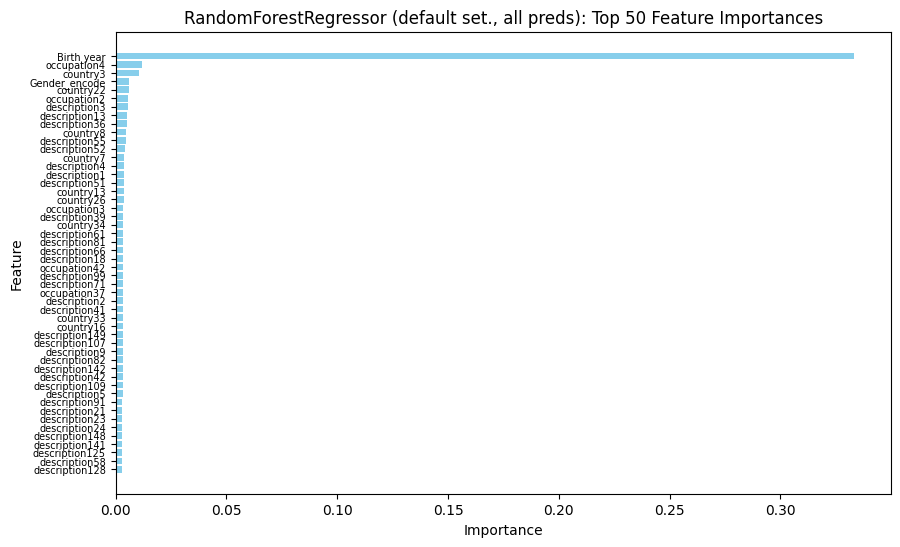

In [50]:
# plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature'], top_features['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.yticks(fontsize = 7)
plt.title(f'RandomForestRegressor (default set., all preds): Top {top_n} Feature Importances')
plt.gca().invert_yaxis()
fig = plt.gcf()
plt.show()

In [51]:
fig.savefig('/work/datascience_exam/output/plots/rfr_feature_importances_full_default.jpg')

In [72]:
# We'll only keep relevant features in the model, so we are setting a threshold of 'importance'
selected_features = feature_importances[feature_importances['Importance'] > 0.003] # this is a very low threshold
selected_features.shape

(58, 2)

In [12]:
# save features so they are easy to reload if anything crashes
#selected_features.to_csv('/work/datascience_exam/output/models/selected_features_importances.csv')
selected_features = pd.read_csv('/work/datascience_exam/output/models/selected_features_importances.csv', index_col = 0)

In [14]:
# get the feature to keep in a list
features_to_keep = selected_features['Feature'].tolist()

# Filter that from X_train
X_train_filtered = X_train[features_to_keep]
X_train_filtered.shape

(510302, 58)

In [75]:
X_train_filtered.to_csv('/work/datascience_exam/data/X_train_filtered.csv', index=False)

In [16]:
# filter validation dataset, too and save
X_val_filtered = X_val[features_to_keep]
X_val_filtered.shape

(109351, 58)

In [77]:
# save X_val_filtered
X_val_filtered.to_csv('/work/datascience_exam/data/X_val_filtered.csv', index=False)

#### Fitting randomforest again

In [18]:
# randomforest model with default parameter values - after feature selection # 64 min

rfreg_58_features = RandomForestRegressor(random_state=42)
rfreg_58_features.fit(X_train_filtered, y_train) 

preds = rfreg_58_features.predict(X_val_filtered)
r2 = r2_score(y_val, preds)
performance = np.sqrt(mean_squared_error(y_val, preds))
performances.append({'model': 'randomforrest_default_58preds', # 'rfr_default_58_features' old name
                        'split': 'validation',
                         'rmse': performance.round(4),
                         'r2': r2.round(4)})

In [19]:
# save model 
#pkl.dump(rfreg_58_features, file=open(f'/work/datascience_exam/output/models/rfr_default_58_features.pkl', 'wb')) # save the model

In [22]:
# reload model
rfreg_58_features = pkl.load(open('/work/datascience_exam/output/models/rfr_default_58_features.pkl','rb'))

In [81]:
print(*performances, sep = '\n')

{'model': 'dummy', 'split': 'validation', 'rmse': 15.9833, 'r2': -0.0}
{'model': 'linear-gender', 'split': 'validation', 'rmse': 15.9637, 'r2': 0.0024}
{'model': 'linear-birth_year', 'split': 'validation', 'rmse': 15.8422, 'r2': 0.0176}
{'model': 'linear-full', 'split': 'validation', 'rmse': 15.3703, 'r2': 0.0752}
{'model': 'linear_lasso_alpha_1.0', 'split': 'validation', 'rmse': 15.8422, 'r2': 0.0176}
{'model': 'linear_ridge_alpha_1.0', 'split': 'validation', 'rmse': 15.3702, 'r2': 0.0752}
{'model': 'knn-allpreds-10', 'split': 'validation', 'rmse': 14.5385, 'r2': 0.1726}
{'model': 'randomforest_default_allpreds', 'split': 'validation', 'rmse': 14.1748, 'r2': 0.2135}
{'model': 'randomforrest_default_58preds', 'split': 'validation', 'rmse': 14.205, 'r2': 0.2101}


In [23]:
# check feature importances again
importances = rfreg_58_features.feature_importances_

# get column names
feature_names = X_train_filtered.columns
# make dataframe
feature_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
# sort by importance
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# get the top 50 features to plot
top_n = 50 
top_features = feature_importances.head(top_n)


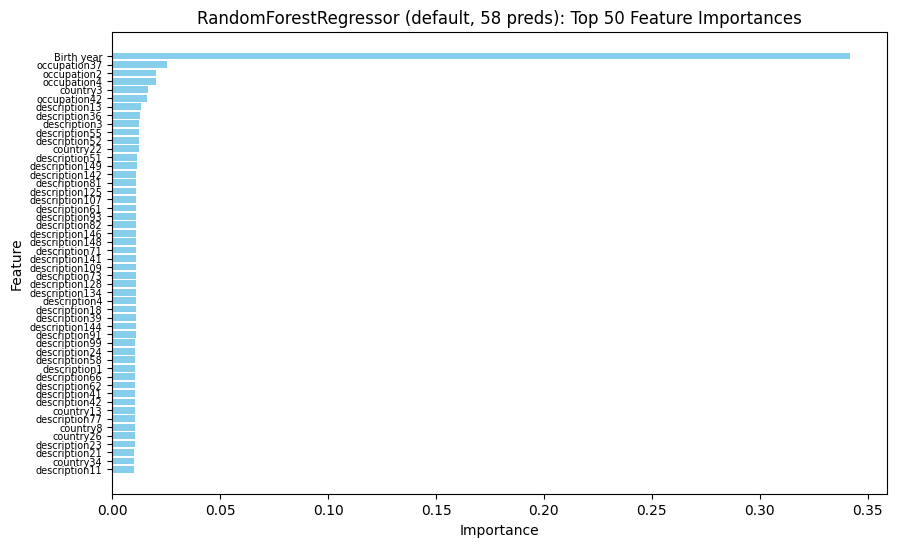

In [25]:
# plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature'], top_features['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.yticks(fontsize = 7)
plt.title(f'RandomForestRegressor (default, 58 preds): Top {top_n} Feature Importances')
plt.gca().invert_yaxis()
fig = plt.gcf()
plt.show()

In [26]:
fig.savefig('/work/datascience_exam/output/plots/rfr_feature_importances_58preds_default.jpg')

The model's performance almost didn't decrease even though I removed many of the features,

which is an indication that many of the features are not important.

I'll now make randomized search cross-validation to explore the best combination of parameters while 

constraining the model by introducing 'stopping' parameters. 



The default parameters of the RandomForest regression can be found below:

Default parameters:
- 'bootstrap': True,
- 'criterion': 'mse',
- 'max_depth': None,
- 'max_features': 'auto',
- 'max_leaf_nodes': None,
- 'min_impurity_decrease': 0.0,
- 'min_impurity_split': None,
- 'min_samples_leaf': 1,
- 'min_samples_split': 2,
- 'min_weight_fraction_leaf': 0.0,
- 'n_estimators': 10, # default only used 10 trees
- 'n_jobs': 1,
- 'oob_score': False,
- 'random_state': 42,
- 'verbose': 0,
- 'warm_start': False}

In [94]:
# random forrest model
rfreg_cv = RandomForestRegressor(random_state=42)

In [40]:
# first version ~90 min 
param_grid = { 
    'n_estimators': [5, 10, 20, 100, 200], # number of trees - deafult is 100
    'max_depth' : [5, 10, 15, 20], # max number of splits/leaves (leaf = node without children) - stopping criteria # default is none
    'min_samples_split': [2, 5, 10], # min. number of samples required to split an internal node, default is 2
    'max_features': [0.3, 0.6, 0.9], # proportion of features to max. use in a tree (subset proportion) - default is 1.0 (= all features)
    'ccp_alpha': [0.01, 0.1, 1.0] # minimal-cost complexity pruning - to overvoid overfitting, default 0.0 
}


In [95]:
# More constraining version ~80 min 
param_grid2 = { 
    'n_estimators': [5, 10, 20, 100, 150], # number of trees - deafult is 100
    'max_depth' : [5, 10, 15, 20], # max number of splits/leaves (leaf = node without children) - stopping criteria # default is none
    'min_samples_split': [2, 5, 10], # min. number of samples required to split an internal node, default is 2
    'max_features': [0.3, 0.6, 0.8], # proportion of features to max. use in a tree (subset proportion) - default is 1.0 (= all features)
    'ccp_alpha': [0.5, 0.7, 1.0] # minimal-cost complexity pruning - to overvoid overfitting, default 0.0 
}

In [96]:

cv_rfr = RandomizedSearchCV(estimator=rfreg_cv, 
                            param_distributions=param_grid2,
                            scoring='neg_root_mean_squared_error', # this is "neg" because CV wants a metric to maximize
                            n_iter=10, 
                            cv=5,
                            verbose = 2,
                            n_jobs = -1)

randomized_search = cv_rfr.fit(X_train_filtered, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END ccp_alpha=0.5, max_depth=10, max_features=0.3, min_samples_split=2, n_estimators=10; total time=  54.9s
[CV] END ccp_alpha=0.7, max_depth=10, max_features=0.6, min_samples_split=10, n_estimators=5; total time=  56.1s
[CV] END ccp_alpha=0.7, max_depth=10, max_features=0.6, min_samples_split=10, n_estimators=5; total time= 1.2min
[CV] END ccp_alpha=0.7, max_depth=10, max_features=0.6, min_samples_split=10, n_estimators=5; total time= 1.2min
[CV] END ccp_alpha=0.5, max_depth=10, max_features=0.3, min_samples_split=2, n_estimators=10; total time= 1.2min
[CV] END ccp_alpha=0.5, max_depth=10, max_features=0.3, min_samples_split=2, n_estimators=10; total time= 1.2min
[CV] END ccp_alpha=0.7, max_depth=10, max_features=0.6, min_samples_split=10, n_estimators=5; total time= 1.2min
[CV] END ccp_alpha=0.5, max_depth=10, max_features=0.3, min_samples_split=2, n_estimators=10; total time= 1.2min
[CV] END ccp_alpha=0.5, max_depth=1

In [97]:
# save 
#pkl.dump(randomized_search, file=open(f'/work/datascience_exam/output/models/randomized_search_cv_58_features_more_constrained.pkl', 'wb')) # save the model

In [10]:
# re-load model - less constraining
randomized_search = pkl.load(open('/work/datascience_exam/output/models/randomized_search_cv_58_features.pkl','rb'))

In [28]:
# re-load model - more constraining
randomized_search = pkl.load(open('/work/datascience_exam/output/models/randomized_search_cv_58_features_more_constrained.pkl','rb'))

In [ ]:
randomized_search.cv_results_

In [123]:
# first version of the randomized search - less constrained
randomized_search.best_params_

{'n_estimators': 200,
 'min_samples_split': 10,
 'max_features': 0.9,
 'max_depth': 10,
 'ccp_alpha': 0.01}

The model maximizes the number of trees, but doesn't maximize tree depth. 

min_smaples_split is also maximized, which should reduce overfitting.

almost all features are used in a tree. ccp_alpha should maybe be more constrained.

In [135]:
# second version of the randomized search - more constrained
randomized_search.best_params_

{'n_estimators': 150,
 'min_samples_split': 10,
 'max_features': 0.6,
 'max_depth': 20,
 'ccp_alpha': 0.7}

Again, model maximizes number of trees. 

This time max_tree_depth is maximized, too.

Now we want to test the tuned model on the validation data 

In [29]:
cv_rfr_tuned = randomized_search.best_estimator_ # has already been fitted

preds = cv_rfr_tuned.predict(X_val_filtered)
r2 = r2_score(y_val, preds)
performance = np.sqrt(mean_squared_error(y_val, preds))
performances.append({'model': 'randomforest_constrained+', 
                        'split': 'validation',
                        'rmse': performance.round(4),
                        'r2': r2.round(4)})

In [53]:
#pkl.dump(cv_rfr_tuned, file=open(f'/work/datascience_exam/output/models/cv_rfr_tuned_58_features.pkl', 'wb')) # save the model

In [30]:
print(*performances, sep = '\n')

{'model': 'dummy', 'split': 'validation', 'rmse': 15.9833, 'r2': -0.0}
{'model': 'linear-gender', 'split': 'validation', 'rmse': 15.9637, 'r2': 0.0024}
{'model': 'linear-birth_year', 'split': 'validation', 'rmse': 15.8422, 'r2': 0.0176}
{'model': 'linear-full', 'split': 'validation', 'rmse': 15.3703, 'r2': 0.0752}
{'model': 'linear_lasso_alpha_1.0', 'split': 'validation', 'rmse': 15.8422, 'r2': 0.0176}
{'model': 'linear_ridge_alpha_1.0', 'split': 'validation', 'rmse': 15.3702, 'r2': 0.0752}
{'model': 'knn-allpreds-10', 'split': 'validation', 'rmse': 14.5385, 'r2': 0.1726}
{'model': 'randomforest_default_allpreds', 'split': 'validation', 'rmse': 14.1748, 'r2': 0.2135}
{'model': 'randomforest_default_58preds', 'split': 'validation', 'rmse': 14.205, 'r2': 0.2101}
{'model': 'randomforest_constrained', 'split': 'validation', 'rmse': 13.8965, 'r2': 0.2441}
{'model': 'randomforest_constrained+', 'split': 'validation', 'rmse': 14.3624, 'r2': 0.1925}


In [39]:
# check feature importances again
importances = cv_rfr_tuned.feature_importances_

# get column names
feature_names = X_train_filtered.columns
# make dataframe
feature_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
# sort by importance
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# get the top 50 features to plot
top_n = 50 
top_features = feature_importances.head(top_n)

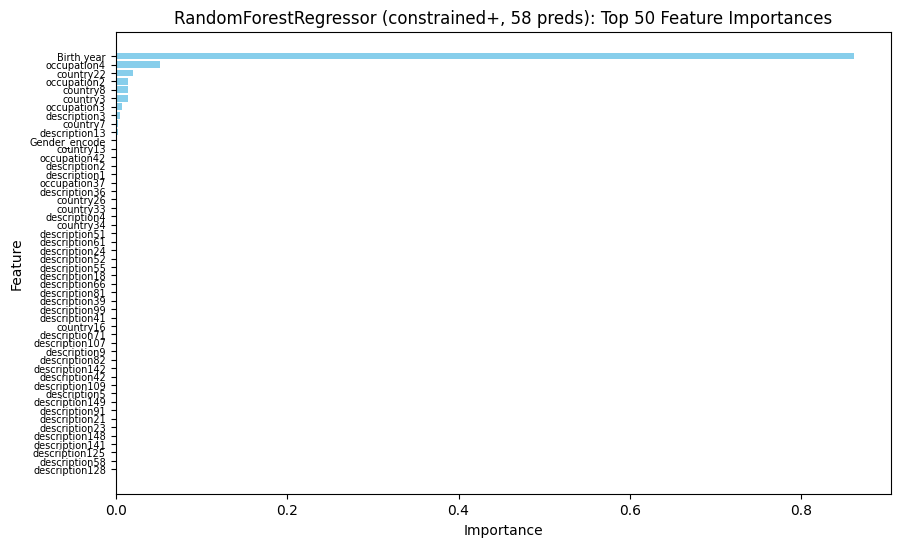

In [40]:
# plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature'], top_features['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.yticks(fontsize = 7)
plt.title(f'RandomForestRegressor (constrained+, 58 preds): Top {top_n} Feature Importances')
plt.gca().invert_yaxis()
fig = plt.gcf()
plt.show()

In [41]:
fig.savefig('/work/datascience_exam/output/plots/rfr_feature_importances_more_constrained.jpg')

### Testing model on the test dataset

In [33]:
# It's time to test the test data. First we need to select the correct features
X_test_filtered = X_test[features_to_keep]
X_test_filtered.shape

(109351, 58)

In [34]:
# The final test; predicting test data
preds = cv_rfr_tuned.predict(X_test_filtered)

r2 = r2_score(y_test, preds)
performance = np.sqrt(mean_squared_error(y_test, preds))
performances.append({'model': 'randomforest_constrained+', 
                        'split': 'test',
                        'rmse': performance.round(4),
                        'r2': r2.round(4)})


In [35]:
print(*performances, sep = '\n')

{'model': 'dummy', 'split': 'validation', 'rmse': 15.9833, 'r2': -0.0}
{'model': 'linear-gender', 'split': 'validation', 'rmse': 15.9637, 'r2': 0.0024}
{'model': 'linear-birth_year', 'split': 'validation', 'rmse': 15.8422, 'r2': 0.0176}
{'model': 'linear-full', 'split': 'validation', 'rmse': 15.3703, 'r2': 0.0752}
{'model': 'linear_lasso_alpha_1.0', 'split': 'validation', 'rmse': 15.8422, 'r2': 0.0176}
{'model': 'linear_ridge_alpha_1.0', 'split': 'validation', 'rmse': 15.3702, 'r2': 0.0752}
{'model': 'knn-allpreds-10', 'split': 'validation', 'rmse': 14.5385, 'r2': 0.1726}
{'model': 'randomforest_default_allpreds', 'split': 'validation', 'rmse': 14.1748, 'r2': 0.2135}
{'model': 'randomforest_default_58preds', 'split': 'validation', 'rmse': 14.205, 'r2': 0.2101}
{'model': 'randomforest_constrained', 'split': 'validation', 'rmse': 13.8965, 'r2': 0.2441}
{'model': 'randomforest_constrained+', 'split': 'validation', 'rmse': 14.3624, 'r2': 0.1925}
{'model': 'randomforest_constrained+', 'spli

/tmp/ipykernel_362/964559479.py:3: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.scatterplot(data=perf_df.sort_values(by='rmse', ascending=False),


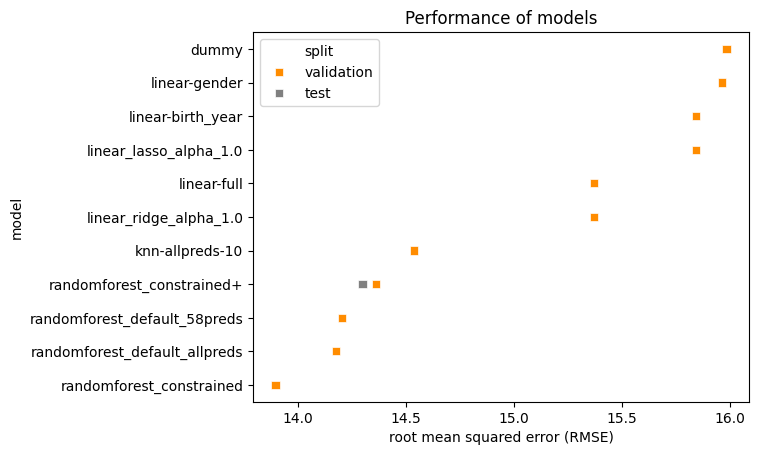

In [45]:
# plotting performances
perf_df = pd.DataFrame(performances)
sns.scatterplot(data=perf_df.sort_values(by='rmse', ascending=False), 
                y='model', 
                x='rmse', 
                marker='s', 
                hue='split', 
                palette=['darkorange', 'grey', 'darkred'])
plt.title("Performance of models")
plt.xlabel("root mean squared error (RMSE)")
fig = plt.gcf() # get current figure
plt.show()

In [46]:
fig.savefig('/work/datascience_exam/output/plots/performances.jpg', bbox_inches='tight')

In [38]:
perf_df.to_csv('/work/datascience_exam/output/models/model_performances_v7.csv')

That's it! The random forest constrained+ model performs a tiny bit better on the test set than on the validation set. But the performance is not overwhelming. 

#### When starting and stopping midway
The code below is for loading the performances df into a dictionary, so the dictionary is nice and neat

Eases plotting etc

In [ ]:
# how to read df into a dictionary
df = pd.read_csv('/work/datascience_exam/output/models/model_performances_v6.csv', index_col = 0)

# make into list format
performances = []

for index, row in df.iterrows():
    row_dict = {}
    for col in df.columns:
        row_dict[col] = row[col]
    performances.append(row_dict)

print(*performances, sep = '\n')